In [2]:
import numpy as np 
import time
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import gc
import cv2

In [3]:
from imaging_functions import show_map, show_map_3d
from noise_functions import perlin_generator, julia, my_perl
from mountains import mountain, voron_mountain
from landscape import landscape_gen

my_landscape = landscape_gen(200,200,num_plates=10,boundaries = True)
print(my_landscape.heights)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20380767136212863, 0.8293919554206323, 0.5157021280322422, 0.9201510095115193, 0.25800331234346274, 0.7440138867278302, 0.16297453976352938, 0.49277429161276576, 0.9802876247591858, 0.6906801660089122]


In [4]:
my_landscape.centroids

array([[  0.        , 200.        ],
       [200.        ,   0.        ],
       [200.        , 200.        ],
       [  0.        ,   0.        ],
       [  0.        , 100.        ],
       [100.        ,   0.        ],
       [100.        , 200.        ],
       [200.        , 100.        ],
       [103.87248431, 165.81623949],
       [158.39408167,  24.05376036],
       [127.57797081,  23.93615075],
       [ 88.57821711, 109.22819798],
       [163.25452721, 178.22691996],
       [130.18335529, 195.70436613],
       [137.9620327 ,   7.20100926],
       [ 31.06902736,  95.94717105],
       [ 72.01677429, 161.97635413],
       [ 35.63386952,  87.95337968]])

(2048, 2048)
(2048, 2048)
41.408785581588745
(2048, 2048)


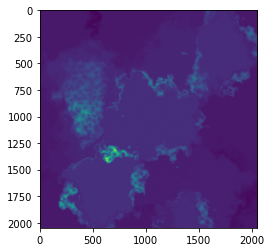

In [5]:
x = y = np.linspace(0,200,2048)
X, Y = np.meshgrid(x,y)

start = time.time()
Z = my_landscape.get_height(X,Y)#, octaves=2,neg_octaves=0, fade=0.5,voron=True,ndims=1)
X, Y = np.meshgrid(x,y)


end = time.time()
print(end-start)
print(Z.shape)
plt.imshow(Z*0.5 + 0.5)

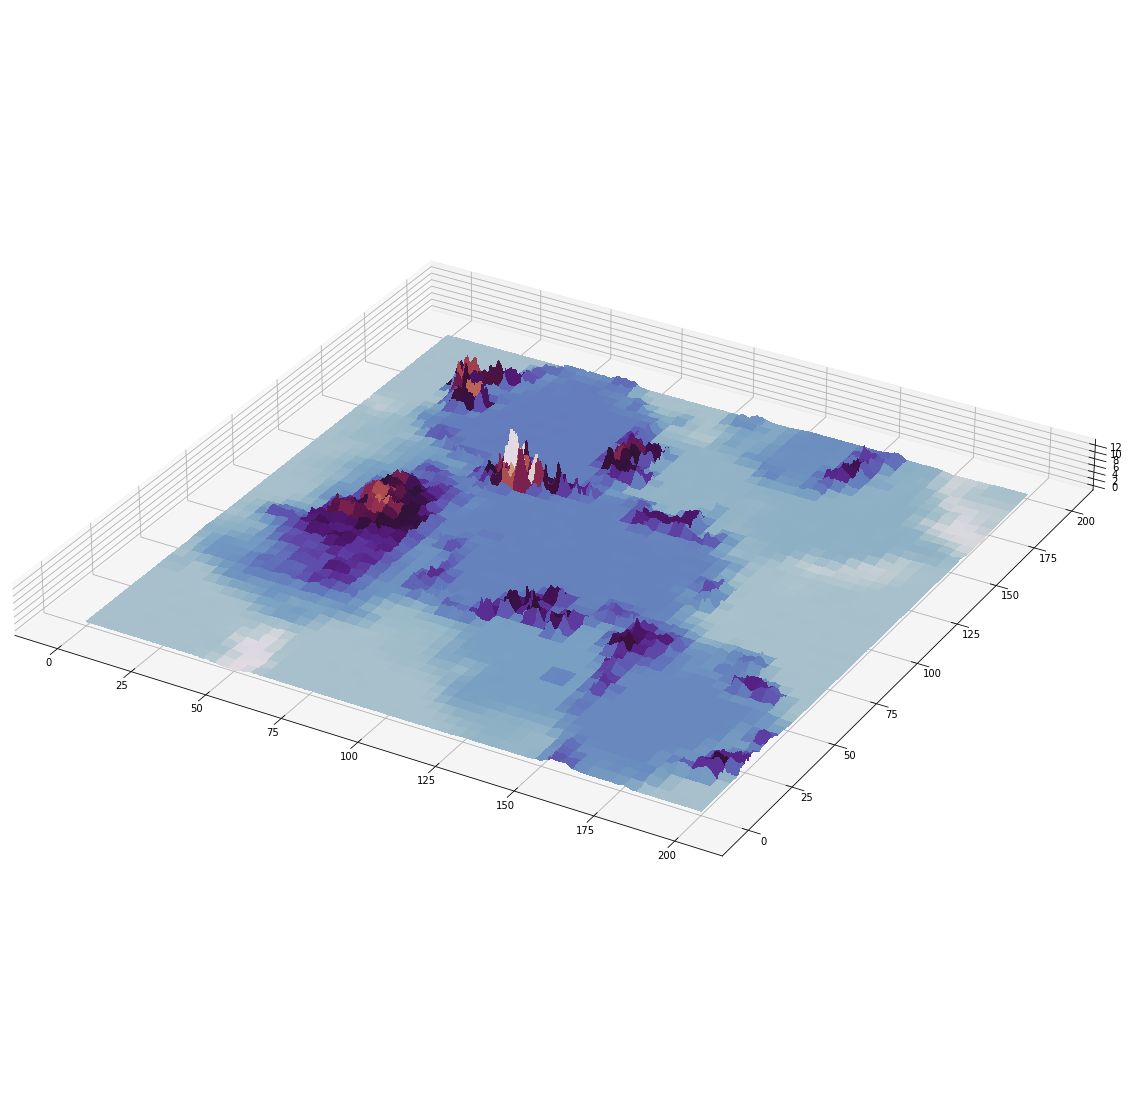

In [6]:
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.075))

#ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [5]:

upres=0.1
offs = [10,-10]
scale = 0.2
start = time.time()
X,Y,Z = show_map_3d(my_perl,int(my_landscape.long*upres),int(my_landscape.lat*upres),scale/upres,[my_landscape.long*0.5+offs[0],my_landscape.lat*0.5+offs[1]],vectorised = False, offset=1,fine_offset=1,mountainsca=1)

end = time.time()
print(end-start)

start = time.time()
X,Y,Z2 = show_map_3d(my_perl,int(my_landscape.long*upres),int(my_landscape.lat*upres),scale/upres,[my_landscape.long*0.5+offs[0],my_landscape.lat*0.5+offs[1]],vectorised = True, offset=1,fine_offset=1,mountainsca=1)

end = time.time()
print(end-start)


0.02219247817993164


TypeError: only size-1 arrays can be converted to Python scalars

In [7]:
np.min(Z)

-0.9806877338932622

Large offset not affecting texture of mountains
Fine offset appears to large-scale at neg-oct=0, changed to -1
Lacking finer details (erosion), changed max octaves from 3 to 4
Fine roughness visible (but only as added texture) at resolution of 200m

In [8]:
Z = Z + -1 * np.min(Z)

In [9]:
Z = Z /np.max(Z)

In [10]:
Z = Z.astype(np.float32)

In [11]:
np.max(Z)

1.0

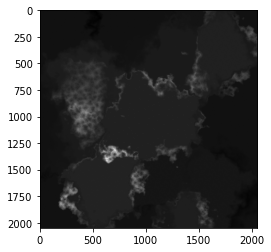

In [12]:
plt.imshow(Z, cmap = "gray")

In [13]:
cv2.imwrite("heightmap4.tiff",Z)#(Z * 255/np.max(Z)))

True

In [247]:
upres = 10

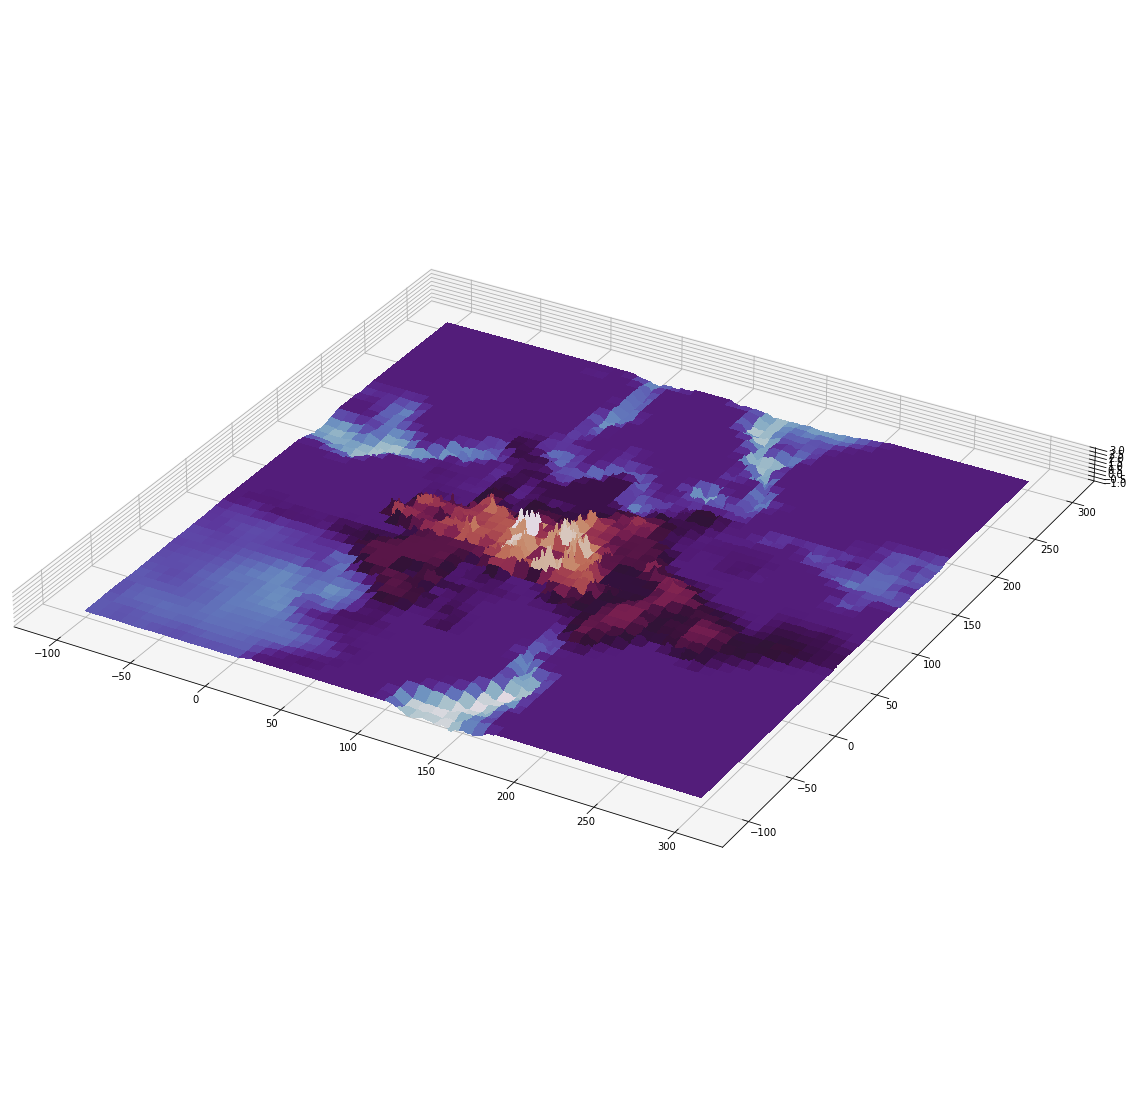

In [248]:

X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),2/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.05))

ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

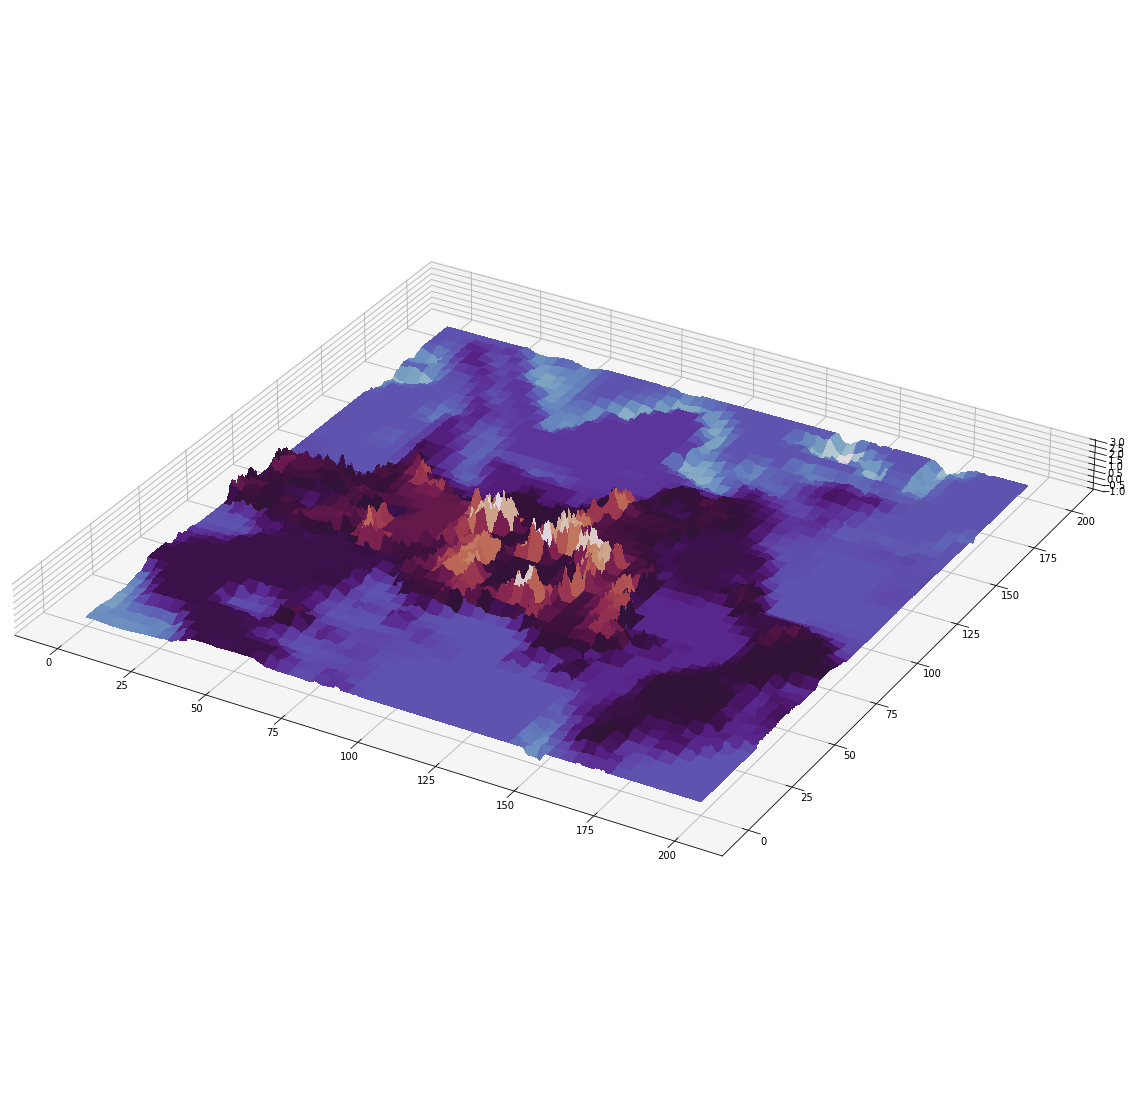

In [249]:
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),1/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])

fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.075))

ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

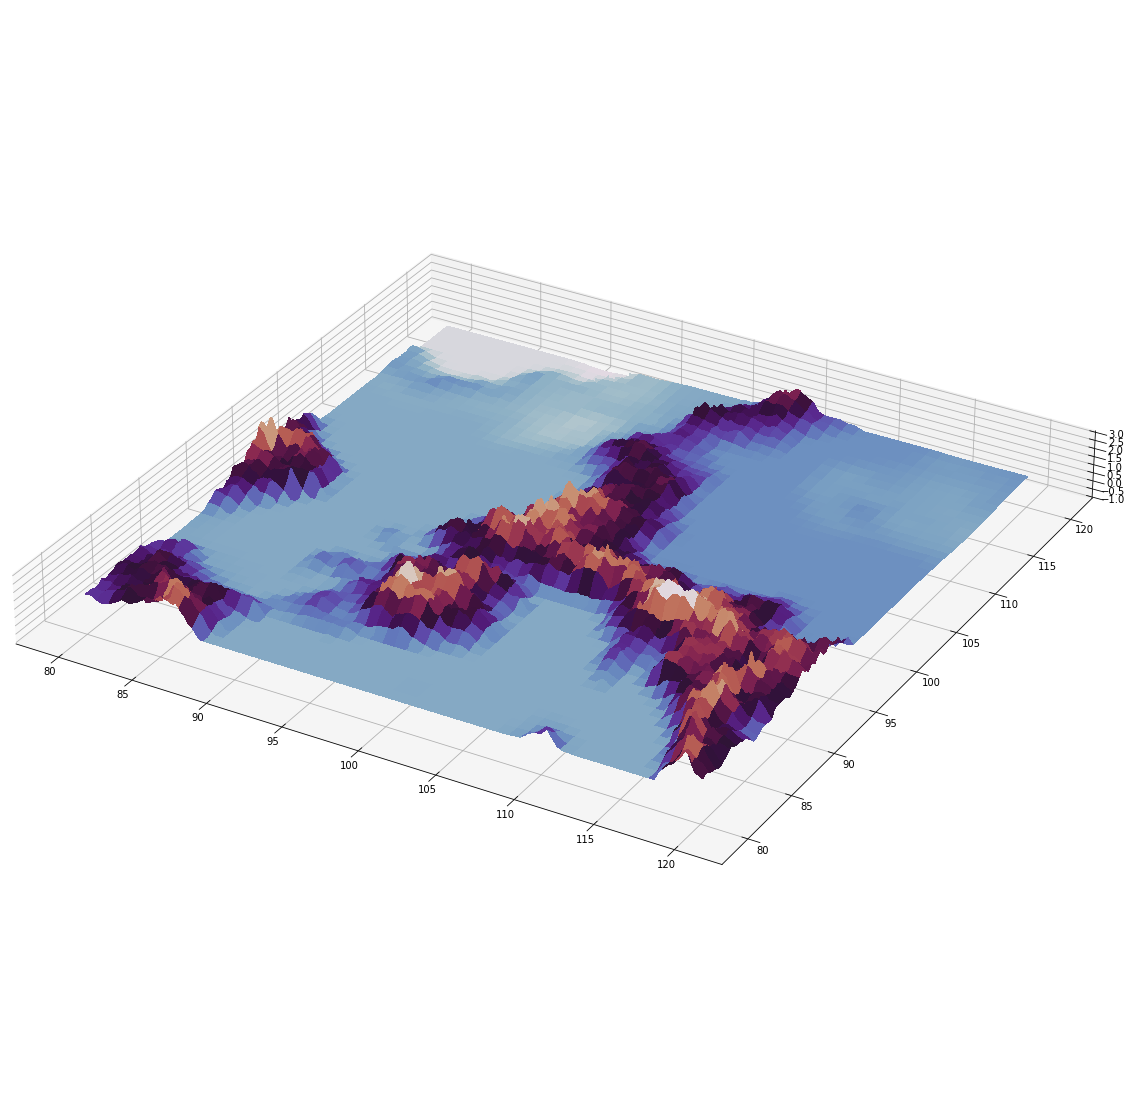

In [250]:
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),0.2/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])

fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.1))

ax.set_zlim(-1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

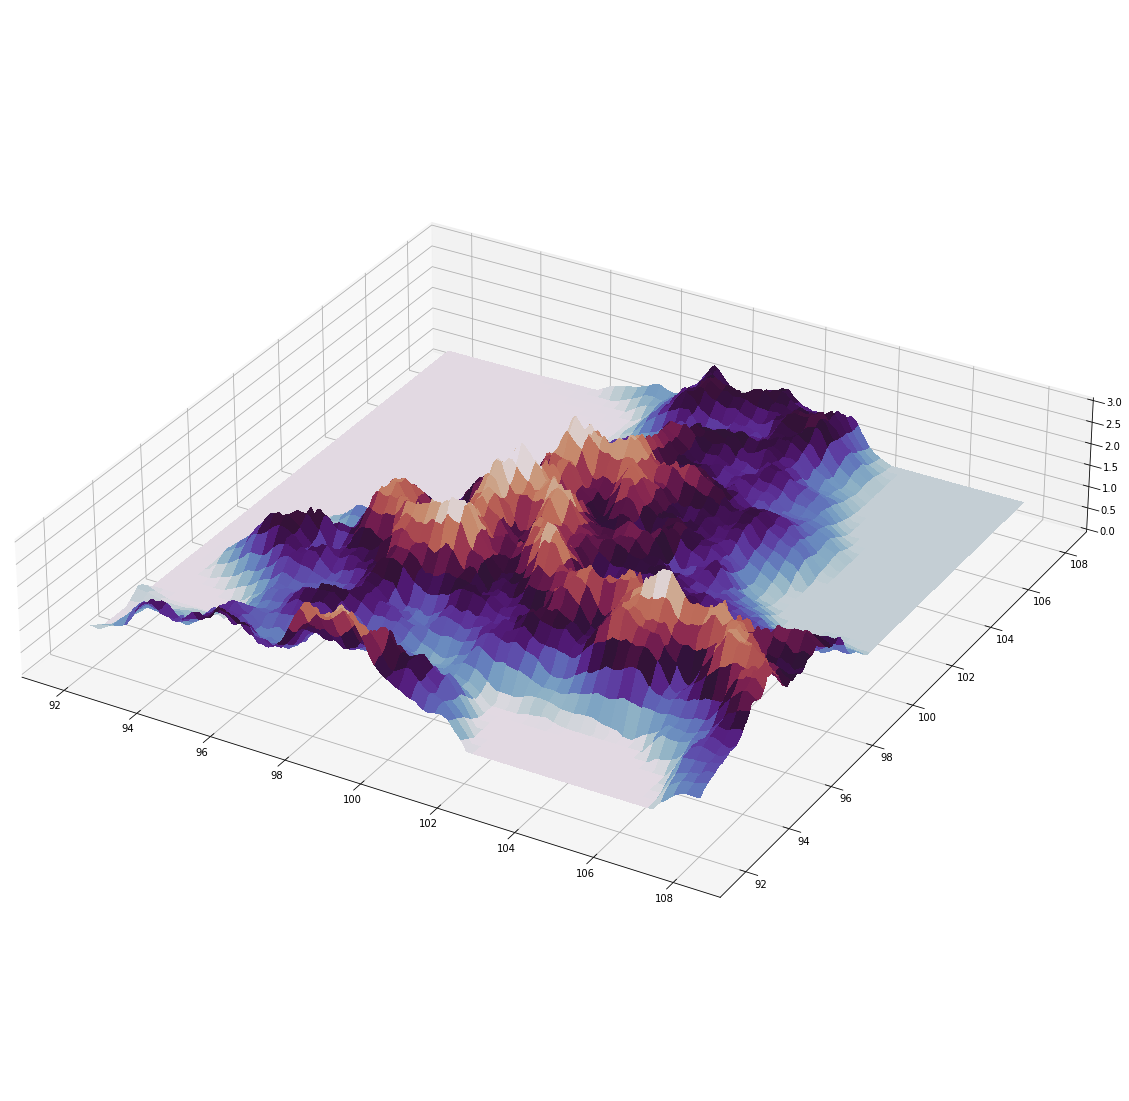

In [251]:
#Slightly Up Close
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),0.08/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.2))

ax.set_zlim(0,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

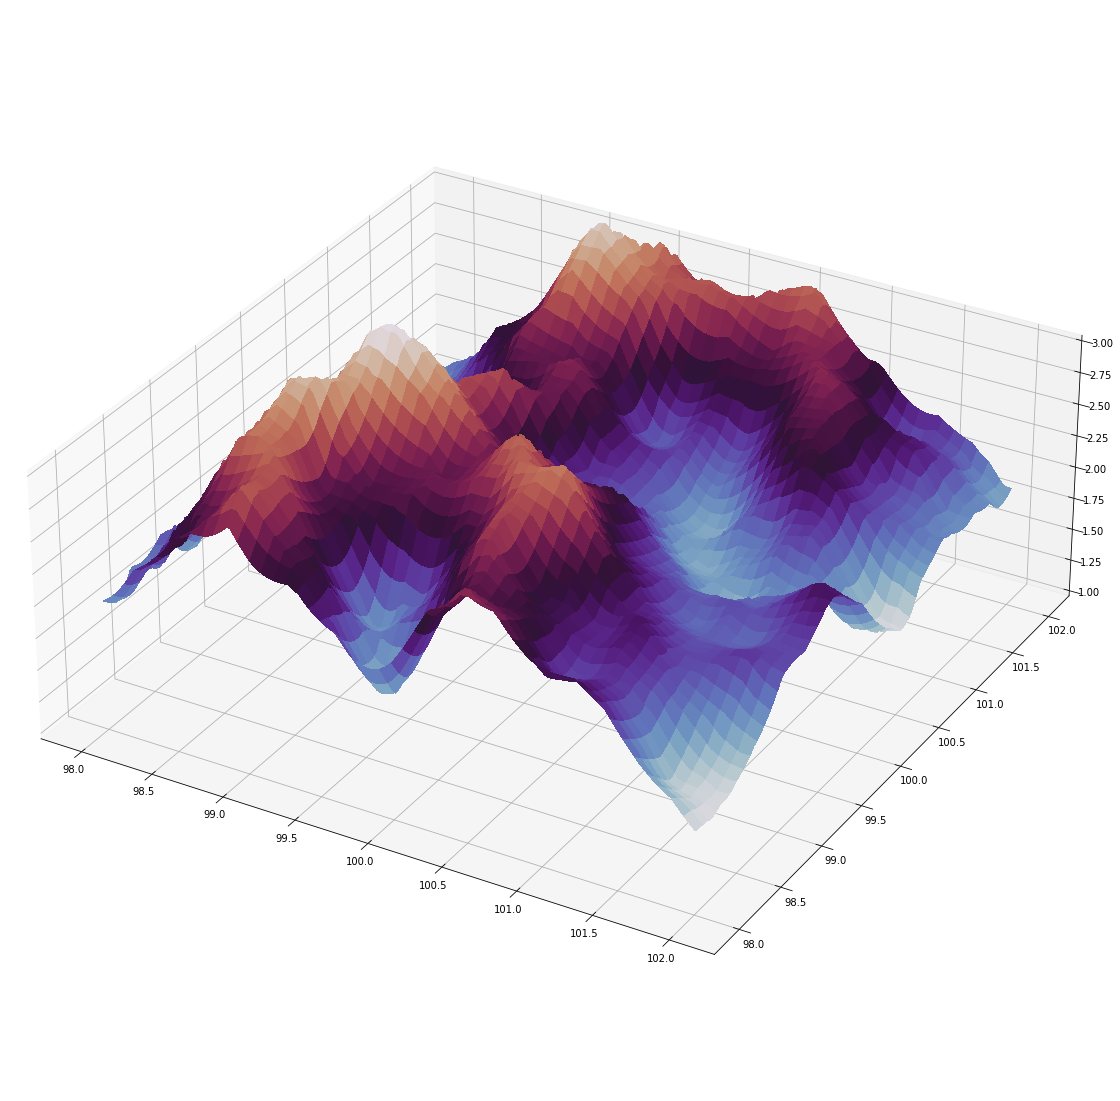

In [252]:
#Up Close
X,Y,Z = show_map_3d(my_landscape,int(my_landscape.long*upres),int(my_landscape.lat*upres),0.02/upres,[my_landscape.long*0.5,my_landscape.lat*0.5])
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_box_aspect((1,1,0.4))

ax.set_zlim(1,3)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

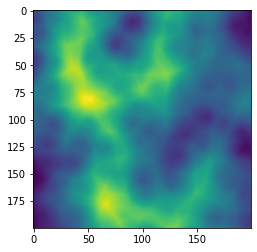

In [228]:
plt.imshow(Z)

In [179]:
my_landscape.centroids

[array([  0, 200]),
 array([100,   0]),
 array([100, 200]),
 array([0, 0]),
 array([  0., 100.]),
 array([50.,  0.]),
 array([ 50., 200.]),
 array([100., 100.]),
 array([89.05212215, 18.09456841]),
 array([ 0.88193504, 30.84390756]),
 array([96.93265666, 30.31454165]),
 array([ 16.47583772, 104.7003559 ]),
 array([17.40071216,  5.49022634]),
 array([ 7.80817072, 85.72547377]),
 array([16.48657516, 23.45700497]),
 array([ 51.24273497, 122.12725281]),
 array([ 92.13250563, 158.83989673]),
 array([ 44.14978359, 101.07777991])]